# Initialization

In [ ]:
import pandas as pd
import numpy as np
import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# fix random seed for reproducibility

seed = 42
np.random.seed(seed)

# Loading Dataset

In [ ]:
# training dataset

df_train = pd.read_parquet('/content/sample_data/train_dl.parquet')

label_column = 'output'

# Separate features (X) and labels (y)
X_train = df_train.drop(columns=['output', 'instruction'])  # Drop 'output' and 'instruction' columns to get features
y_train = df_train['output']  # Set 'output' column as the label

# Inspect features (X) and labels (y)
print("Features (X):")
print(X_train.head())
print("\nLabels (y):")
print(y_train.head())

Features (X):
                                               input
0  $BYND - JPMorgan reels in expectations on Beyo...
1  $CCL $RCL - Nomura points to bookings weakness...
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...
3  $ESS: BTIG Research cuts to Neutral https://t....
4  $FNKO - Funko slides after Piper Jaffray PT cu...

Labels (y):
0    negative
1    negative
2    negative
3    negative
4    negative
Name: output, dtype: object


In [ ]:
# validation dataset
df_valid = pd.read_parquet('/content/sample_data/validation_dl.parquet')


# Separate features (X) and labels (y)
X_valid = df_valid.drop(columns=['output', 'instruction'])  # Drop 'output' and 'instruction' columns to get features
y_valid = df_valid['output']  # Set 'output' column as the label

# Inspect features (X) and labels (y)
print("Features (X):")
print(X_valid.head())
print("\nLabels (y):")
print(y_valid.head())

Features (X):
                                               input
0  $ALLY - Ally Financial pulls outlook https://t...
1  $DELL $HPE - Dell, HPE targets trimmed on comp...
2  $PRTY - Moody's turns negative on Party City h...
3                   $SAN: Deutsche Bank cuts to Hold
4                  $SITC: Compass Point cuts to Sell

Labels (y):
0    negative
1    negative
2    negative
3    negative
4    negative
Name: output, dtype: object


# Preprocessing

In [ ]:
# 1. Normalization of misspelled words (You'll need a dictionary for this step)

# Example dictionary
misspelled_dict = {
    'mispeling': 'misspelling',
    'writen': 'written',
    # Add more entries as needed
}

def normalize_misspelled(text_data):
    for misspelled, corrected in misspelled_dict.items():
        text_data = text_data.replace(misspelled, corrected)
    return text_data

df_train['input'] = df_train['input'].apply(normalize_misspelled)
df_valid['input'] = df_valid['input'].apply(normalize_misspelled)

In [ ]:
# 2. Lowercasing

def lowercase(text_data):
    return text_data.lower()

df_train['input'] = df_train['input'].apply(lowercase)
df_valid['input'] = df_valid['input'].apply(lowercase)

In [ ]:
# 3. Remove URLs and Hashtags

import re

def remove_url_hashtags(text_data):
    text_data = re.sub(r"http\S+", "", text_data)  # Remove URLs
    text_data = re.sub(r"#\S+", "", text_data)     # Remove hashtags
    return text_data

df_train['input'] = df_train['input'].apply(remove_url_hashtags)
df_valid['input'] = df_valid['input'].apply(remove_url_hashtags)

In [ ]:
# 4. Replace tabs and line breaks with a blank, and quotation marks with apostrophes

def replace_special_characters(text_data):
    text_data = text_data.replace('\t', ' ')    # Replace tabs with a blank
    text_data = text_data.replace('\n', ' ')    # Replace line breaks with a blank
    text_data = text_data.replace('"', "'")     # Replace quotation marks with apostrophes
    return text_data

df_train['input'] = df_train['input'].apply(replace_special_characters)
df_valid['input'] = df_valid['input'].apply(replace_special_characters)

In [ ]:
# 5. Remove punctuation, except for apostrophes

def remove_punctuation(text_data):
    punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for char in punctuation:
        text_data = text_data.replace(char, '')
    return text_data

df_train['input'] = df_train['input'].apply(remove_punctuation)
df_valid['input'] = df_valid['input'].apply(remove_punctuation)


In [ ]:
# 6. Remove vowels repeated in sequence at least three times

def remove_repeated_vowels(text_data):
    vowels = 'aeiou'
    for vowel in vowels:
        pattern = vowel + '{3,}'
        text_data = re.sub(pattern, vowel*2, text_data)  # Replace repeated vowels with two occurrences
    return text_data

df_train['input'] = df_train['input'].apply(remove_repeated_vowels)
df_valid['input'] = df_valid['input'].apply(remove_repeated_vowels)


In [ ]:
# 7. Convert emoticons into sentiment tags (You'll need a dictionary for this step)

# Example dictionary
emoticon_dict = {
    ':)': 'happy',
    ':(': 'sad',
    # Add more entries as needed
}

def convert_emoticons(text_data):
    for emoticon, sentiment in emoticon_dict.items():
        text_data = text_data.replace(emoticon, sentiment)
    return text_data

df_train['input'] = df_train['input'].apply(convert_emoticons)
df_valid['input'] = df_valid['input'].apply(convert_emoticons)

In [ ]:
# 8. Remove numbers

def remove_numbers(text_data):
    return ''.join(word for word in text_data if not word.isdigit())

df_train['input'] = df_train['input'].apply(remove_numbers)
df_valid['input'] = df_valid['input'].apply(remove_numbers)

In [ ]:
# 9. Remove Foreign characters

def remove_foreign_characters(text_data):
		# Remove non-English characters using regex
		return re.sub(r'[^\x00-\x7F]+', '', text_data)

df_train['input'] = df_train['input'].apply(remove_foreign_characters)
df_valid['input'] = df_valid['input'].apply(remove_foreign_characters)

In [ ]:
# TF-IDF weighting scheme

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(df_train['input'])
tfidf_valid = tfidf_vectorizer.transform(df_valid['input'])

In [ ]:
# Stemming

from nltk.stem import PorterStemmer

porter = PorterStemmer()

def stemming(text_data):
    return ' '.join(porter.stem(word) for word in text_data.split())

df_train['input'] = df_train['input'].apply(stemming)
df_valid['input'] = df_valid['input'].apply(stemming)

In [ ]:
# Tokenization
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def tokenize(text_data):
    return word_tokenize(text_data)

df_train['input'] = df_train['input'].apply(tokenize)
df_valid['input'] = df_valid['input'].apply(tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Oversampling

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler


# Print original class distribution
print("Original class distribution in training data:")
print(df_train['output'].value_counts())

print("Original class distribution in validation data:")
print(df_valid['output'].value_counts())

# Parameters
max_words = 10000
maxlen = 140  # maximum length of a tweet

# Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['input'])

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(df_train['input'])
X_valid_sequences = tokenizer.texts_to_sequences(df_valid['input'])

# Padding sequences
X_train_pad = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_valid_pad = pad_sequences(X_valid_sequences, maxlen=maxlen, padding='post')

# Calculate class distribution
class_distribution = df_train['output'].value_counts()

# Identify minority class
minority_class = class_distribution.idxmin()

# Determine the number of samples in the minority class
minority_samples = class_distribution[minority_class]

# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and apply oversampling to training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_pad, y_train)

# Fit and apply oversampling to training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_pad, y_train)

# Convert labels to binary format if needed
encoder = LabelEncoder()
encoded_y_train_resampled = encoder.fit_transform(y_train_resampled)

# Convert labels to categorical
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_valid_cat = pd.get_dummies(y_valid).values

print("Resampled X shape:", X_train_resampled.shape)
print("Resampled y distribution:", np.bincount(encoded_y_train_resampled))

# Print class distribution after oversampling
print("Class distribution in training data after oversampling:")
print(pd.Series(y_train_resampled).value_counts())

print("Class distribution in validation data (unchanged):")
print(df_valid['output'].value_counts())

Original class distribution in training data:
output
neutral     6178
positive    1923
negative    1442
Name: count, dtype: int64
Original class distribution in validation data:
output
neutral     1566
positive     475
negative     347
Name: count, dtype: int64
Resampled X shape: (18534, 140)
Resampled y distribution: [6178 6178 6178]
Class distribution in training data after oversampling:
output
negative    6178
positive    6178
neutral     6178
Name: count, dtype: int64
Class distribution in validation data (unchanged):
output
neutral     1566
positive     475
negative     347
Name: count, dtype: int64


# CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam

# Model Architecture
embedding_dim = 300
filters = 128
kernel_size = 5

cnn_model = Sequential()
cnn_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
cnn_model.add(Conv1D(filters, kernel_size, activation='elu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size, activation='elu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size, activation='elu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size, activation='elu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(3, activation='softmax'))  # 3 classes: positive, negative, neutral

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Training the model
cnn_history = cnn_model.fit(X_train_resampled, y_train_resampled_cat,
                            epochs=25,
                            batch_size=32,
                            validation_data=(X_valid_pad, y_valid_cat))

# Evaluating the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_valid_pad, y_valid_cat)
print("CNN Validation Accuracy:", cnn_accuracy)

# Predictions and Classification Report
cnn_y_pred = cnn_model.predict(X_valid_pad)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis=1)
cnn_y_true = np.argmax(y_valid_cat, axis=1)

print(classification_report(cnn_y_true, cnn_y_pred_classes, target_names=encoder.classes_))

Epoch 1/25
580/580 [==============================] - 131s 223ms/step - loss: 0.7050 - accuracy: 0.6552 - val_loss: 0.5792 - val_accuracy: 0.7755
Epoch 2/25
580/580 [==============================] - 128s 222ms/step - loss: 0.1684 - accuracy: 0.9486 - val_loss: 0.7887 - val_accuracy: 0.8132
Epoch 3/25
580/580 [==============================] - 127s 220ms/step - loss: 0.0755 - accuracy: 0.9790 - val_loss: 0.8969 - val_accuracy: 0.8124
Epoch 4/25
580/580 [==============================] - 130s 224ms/step - loss: 0.0408 - accuracy: 0.9894 - val_loss: 0.9167 - val_accuracy: 0.8057
Epoch 5/25
580/580 [==============================] - 127s 220ms/step - loss: 0.0390 - accuracy: 0.9894 - val_loss: 1.2118 - val_accuracy: 0.7835
Epoch 6/25
580/580 [==============================] - 127s 218ms/step - loss: 0.0380 - accuracy: 0.9899 - val_loss: 1.3924 - val_accuracy: 0.8011
Epoch 7/25
580/580 [==============================] - 134s 231ms/step - loss: 0.0252 - accuracy: 0.9929 - val_loss: 1.4999 -

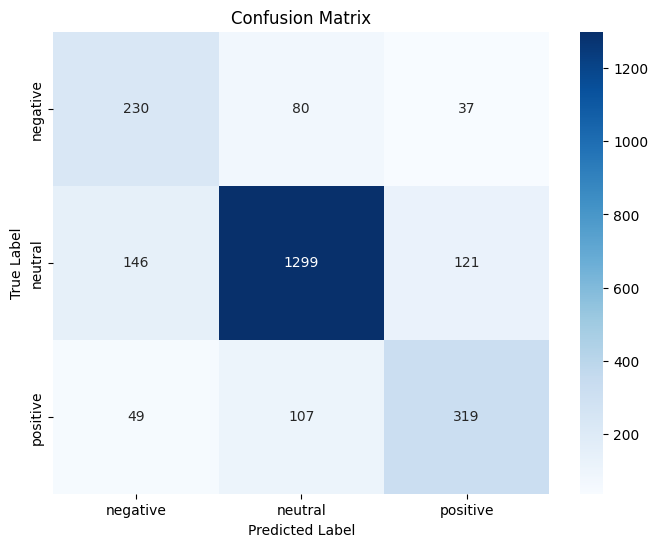

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
conf_matrix1 = confusion_matrix(cnn_y_true, cnn_y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

# Model Architecture
embedding_dim = 100
lstm_units = 128

rnn_model = Sequential()
rnn_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
rnn_model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(3, activation='softmax'))  # 3 classes: positive, negative, neutral

rnn_model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Training the model
rnn_history = rnn_model.fit(X_train_resampled, y_train_resampled_cat,
                            epochs=25,
                            batch_size=32,
                            validation_data=(X_valid_pad, y_valid_cat))

# Evaluating the model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_valid_pad, y_valid_cat)
print("RNN Validation Accuracy:", rnn_accuracy)

# Predictions and Classification Report
rnn_y_pred = rnn_model.predict(X_valid_pad)
rnn_y_pred_classes = np.argmax(rnn_y_pred, axis=1)
rnn_y_true = np.argmax(y_valid_cat, axis=1)

print(classification_report(rnn_y_true, rnn_y_pred_classes, target_names=encoder.classes_))

Epoch 1/25
580/580 [==============================] - 252s 426ms/step - loss: 1.0995 - accuracy: 0.3396 - val_loss: 1.0916 - val_accuracy: 0.6558
Epoch 2/25
580/580 [==============================] - 247s 426ms/step - loss: 1.0989 - accuracy: 0.3258 - val_loss: 1.0962 - val_accuracy: 0.6558
Epoch 3/25
580/580 [==============================] - 252s 434ms/step - loss: 1.0991 - accuracy: 0.3361 - val_loss: 1.1049 - val_accuracy: 0.1453
Epoch 4/25
580/580 [==============================] - 247s 427ms/step - loss: 1.0991 - accuracy: 0.3341 - val_loss: 1.1010 - val_accuracy: 0.1989
Epoch 5/25
580/580 [==============================] - 246s 424ms/step - loss: 1.0989 - accuracy: 0.3310 - val_loss: 1.0997 - val_accuracy: 0.1453
Epoch 6/25
580/580 [==============================] - 246s 424ms/step - loss: 1.0990 - accuracy: 0.3316 - val_loss: 1.0898 - val_accuracy: 0.6558
Epoch 7/25
580/580 [==============================] - 247s 427ms/step - loss: 1.0989 - accuracy: 0.3319 - val_loss: 1.0924 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


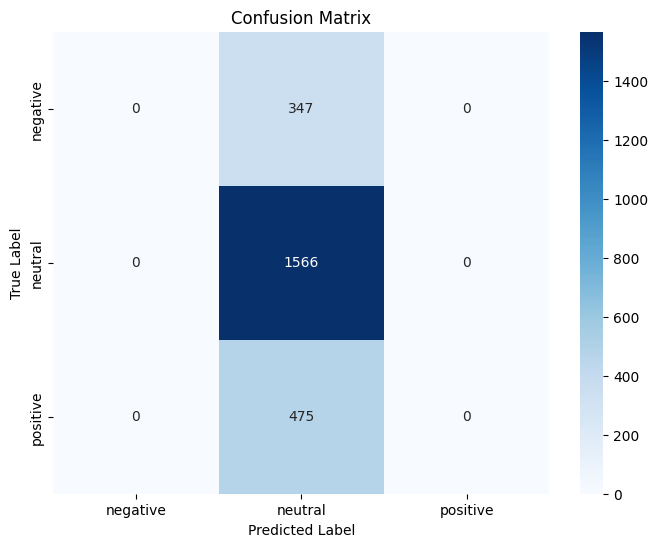

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(rnn_y_true, rnn_y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()